# Tutorial 3:

In this tutorial we are going to cover causal inference. 

### 0.0 Setup

In [1]:
# import Python packages
%matplotlib inline  
import pandas as pd 
import numpy as np  
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
from functools import reduce
plt.rcParams["figure.figsize"] = [10,8]  # Set default figure size

# set a random seed
np.random.seed(12345)

### 1 OVB:

##### 1.1 Simulating data:

For this exercise, we will assume the following DGP in population:

$$
 y = \alpha + \beta_1 \cdot x_1 + \beta_2\cdot w + \varepsilon, \: \: \varepsilon\sim N(0,1) 
$$

$x_1$ and $w$ are related in the following way:

$$
w = \pi \cdot x_1 + u, \: \: u \sim N(0,1)
$$


As in the lecture, $w$ denotes an omitted variable. To make the problem less abstract, suppose that the data set contains observations on working individuals. $y$ denotes hourly wage, $x_1$ denotes years of education, and $w$ denotes innate ability, which cannot be observed.


What do you think:
* Are wages and education positively or negatively correlated?
* Are wages and ability positively or negatively correlated?
* Are ability and education positively or negatively correlated?
* In which direction do you expect the bias to go?


In [2]:
def simul(N, π, α, β1, β2):
    """
    This function simulates a data set that to illustrate the effects of OVB.
    
    The population model is given by: 
        y = α + β1*x1 + β2*w + ε 
        w and x1 are correlated random variables that both have a causal effect on y
        
    To create correlation, w is generated as:
        w = π*x1 + u
        
    ε and u are residuals, γ1, β1 and β2 are regression coefficients. 
        
    """
    
    # draw x1, u, and ε
    x1 = np.random.randn(N)
    u  = np.random.randn(N)
    ε  = np.random.randn(N)
    
    # generate x2 such that it is correlated with x1
    w = π*x1 + u
    
    # generate y
    y = α + β1*x1 + β2*w + ε
    
    return y, x1, w

Let us now simulate some data with a 1000 observations. 

In [3]:
N  = 1000
π  = 0.5
α  = 1
β1 = 0.3
β2 = 0.6

simulated_data = simul(N, π, α, β1, β2)

To make the problem less abstract, let's check whether the variables are indeed correlated. Since we know the true DGP, we can compute the correlation analytically:

Inserting for `w` into the equation for `y`, we get:

$$
    y = \alpha + \beta_1 \cdot x_1 + \beta_2\cdot(\pi \cdot x_1 + u) + \varepsilon 
$$

The correlation coefficient of $y$ and $x_1$ is given by (you can confirm the algebra at home): 

In [4]:
(β1 + β2*π) / np.sqrt(β1**2 + (β2**2)*(π**2) + β1*β2*π*2 + β2**2 + 1)

0.457495710997814

Let's now compute the correlation between `y` and `x1` and `w` using `pd.corrcoef` as well. 

In [5]:
np.corrcoef(simulated_data)

array([[1.        , 0.45898365, 0.60515368],
       [0.45898365, 1.        , 0.46739167],
       [0.60515368, 0.46739167, 1.        ]])

As we can see, our predictions are correct. Both `x1` and `w` are correlated with one another and the outcome variable `y`. Our function thus seems to do its job. We can now turn to estimating regressions including and excluding `w`. Will OLS be able to uncover the true coefficient?

##### 1.2 Estimating the population  model (including $w$):

In [6]:
# import statsmodels
import statsmodels.api as sm

# setting up the regression matrices
Y = simulated_data[0][:,None]

# add a constant
X = np.hstack((np.ones([Y.shape[0],1]), simulated_data[1][:,None], simulated_data[2][:,None]))

# run the regression
model = sm.OLS(Y, X)
results = model.fit()

# display output table
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     340.6
Date:                Fri, 23 Apr 2021   Prob (F-statistic):          1.84e-113
Time:                        19:26:52   Log-Likelihood:                -1419.4
No. Observations:                1000   AIC:                             2845.
Df Residuals:                     997   BIC:                             2860.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0088      0.032     31.834      0.000       0.947       1.071
x1             0.2987      0.037      8.162      0.000       0.227       0.370
x2             0.5621      0.031     18.101      0.000       0.501       0.623
==============================================================================
Omnibus:                        3.664   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.160   Jarque-Bera (JB):                3.292
Skew:                          -0.074   Prob(JB):                        0.193
Kurtosis:                       2.761   Cond. No.                         1.71
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As we can see from the estimation output, OLS applied to the "true" model yields consistent parameter estimates. Let's now omit `w` from the model to see the effect of omitted variable bias.

##### 1.3 Estimating the model without `w`:

In [7]:
# add a constant
X = np.hstack((np.ones([Y.shape[0],1]), simulated_data[1][:,None]))

# run the regression
model = sm.OLS(Y, X)
results = model.fit()

# display output table
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     266.4
Date:                Fri, 23 Apr 2021   Prob (F-statistic):           2.96e-53
Time:                        19:26:52   Log-Likelihood:                -1561.5
No. Observations:                1000   AIC:                             3127.
Df Residuals:                     998   BIC:                             3137.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0178      0.037     27.880      0.000       0.946       1.089
x1             0.6083      0.037     16.320      0.000       0.535       0.681
==============================================================================
Omnibus:                        1.643   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.440   Jarque-Bera (JB):                1.706
Skew:                          -0.076   Prob(JB):                        0.426
Kurtosis:                       2.867   Cond. No.                         1.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As we can see, OLS fails to consistently estimate the true parameters, because on of the fundamental assumptions is violated. Also, note that we can even reject `H0: β1 = 0.3`! This can lead to wrong conclusions in real life applications! Keep in mind that these results are invalid!

###### The size and direction of the bias

In class we showed that in the case of OVB, OLS will falsely attribute parts of the effect of `w` on `y` to `x1`.

Formally:

$$
\hat{\delta} = \hat{\beta_1} + \hat{\beta_2}\cdot \hat{\pi}
$$

Given our simulated data and the regression output from above, we can confirm this result.

In [8]:
δ1 = β1 + β2*π
print(δ1)

0.6


The remaining differences from this result are due to sampling variability.

In class you also learned how the bias depends on the sign of the true parameters. As a reminder:

|            | Corr(x1,w)>0 |  Corr(x1,w)<0 |
| :---       |    :----:     |     :----:     | 
| β2>0       |       +       |        -       |  
| β2<0       |       -       |        +       |

Since `x1` and `w`, as well as `w` and `y` are positively correlated, we find the coefficient to be positively biased in our simulation. As a counterexample, let's generate a new DGP where $\beta_2$ is negative and re-run out estimation excluding `w` from the regression.

In [9]:
# simulate a new DGP with negative β2
simulated_data2 = simul(N, π, α, β1, -β2)

# extract Y
Y = simulated_data2[0][:,None]

# add a constant
X = np.hstack((np.ones([Y.shape[0],1]), simulated_data2[1][:,None]))

# run the regression
model = sm.OLS(Y, X)
results = model.fit()

# display output table
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1449
Date:                Fri, 23 Apr 2021   Prob (F-statistic):              0.704
Time:                        19:26:53   Log-Likelihood:                -1550.4
No. Observations:                1000   AIC:                             3105.
Df Residuals:                     998   BIC:                             3115.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0232      0.036     28.342      0.000       0.952       1.094
x1            -0.0138      0.036     -0.381      0.704      -0.085       0.057
==============================================================================
Omnibus:                        0.464   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.793   Jarque-Bera (JB):                0.479
Skew:                           0.052   Prob(JB):                        0.787
Kurtosis:                       2.977   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As we can see, the estimated coefficient is now negative. Moreover, we can no longer reject `H0: β1 = 0`. Let's plug it into out formula for calculating the bias:

In [10]:
δ1 = β1 + -β2*π
print(δ1)

0.0


While the true coefficient from the simulation is 0.3, the correlation structure between `x1`, `w`, and `y` is such that OLS will underestimate the effect of `x1` on `y`. In our case the bias is so large that OLS will estimate the effect to be 0! Recall that the effect is positive and equal to 0.3 in our simulations! 

###### 1.4 Control variables:

Lastly, let's suppose that we have a control variable at hand that is correlated with `w`. For simplicity, let's assume:

$$
x_3 = a + b \cdot w + \xi, \: \: \: \xi \sim N(0,1) 
$$

We will write a function and see how the inclusion of a control variable impacts our bias.

In [11]:
def genX3(w, a, b):
    
    """
    This function simulates a control variable.
    """
    
    # read out N
    N = len(w)
    
    # generate x3
    x3 = a + b*w + np.random.rand(N)[:,None]
    
    return x3

To start off, let's compute an example with `a=0` and `b=0.5`.

In [12]:
x3 = genX3(simulated_data[2][:,None], 0, 0.5)

# extract Y
Y = simulated_data[0][:,None]

# add a constant
X = np.hstack((np.ones([Y.shape[0],1]), simulated_data[1][:,None], x3))

# run the regression
model = sm.OLS(Y, X)
results = model.fit()

# display output table
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     281.4
Date:                Fri, 23 Apr 2021   Prob (F-statistic):           1.24e-97
Time:                        19:26:53   Log-Likelihood:                -1456.0
No. Observations:                1000   AIC:                             2918.
Df Residuals:                     997   BIC:                             2933.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5895      0.043     13.658      0.000       0.505       0.674
x1             0.3736      0.037     10.126      0.000       0.301       0.446
x2             0.8454      0.055     15.306      0.000       0.737       0.954
==============================================================================
Omnibus:                        6.330   Durbin-Watson:                   2.073
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                5.248
Skew:                          -0.093   Prob(JB):                       0.0725
Kurtosis:                       2.698   Cond. No.                         2.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see that the bias is less extreme in this case. Finally, let's investigate how the bias of depends on the correlation between `w` and `x3`, so the omitted variable and our control. 

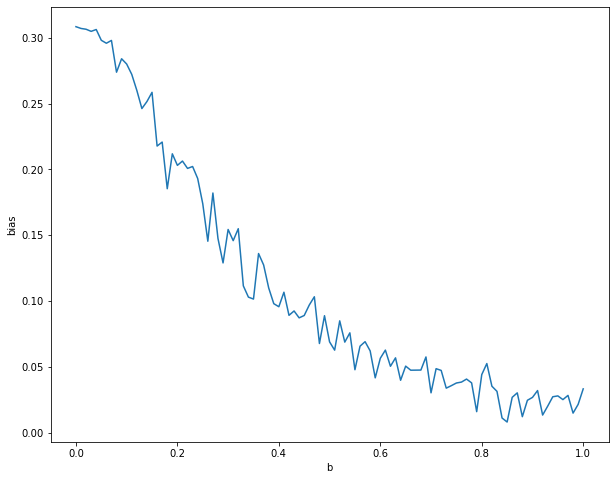

In [13]:

# define a function that computes the bias for different values of b
def get_bias(Y, X1, w, β1, b):
    
    """
    function for computing the bias based on different b
    """
    
    bias = []
    
    for i in b:

        X3 = genX3(w, 0, i)
        
        X = np.hstack((np.ones([Y.shape[0],1]), X1, X3))
    
        # run the regression
        model = sm.OLS(Y, X)
        results = model.fit()
        
        bias.append(results.params[1] - β1)
    
    return bias

# create an interval for b
b = np.arange(0,1.01,0.01)

# call the get_bias function
bias = get_bias(Y, simulated_data[1][:,None], simulated_data[2][:,None], β1, b)

# plot the results
fig, ax = plt.subplots()
ax.plot(b, bias)
plt.xlabel('b')
plt.ylabel('bias')
plt.show()


Thus, the more highly the control variable is correlated with the omitted variable, the smaller the bias in the OLS parameter. It also tells you, however, that the added controls must be useful. Just adding a bunch of controls as such is not going to mitigate the ovb and we should not place more trust into models just because they are larger. 

### 2.0 Instrumental variables:

We are again going to simulate a DGP to illustrate 2SLS.

Let us assume the following model:

$$
X_1 = \gamma\cdot Z + \xi, \:\: \xi\sim N(0,1)
$$

$$
Y = \beta_0 + \beta_1 \cdot X_1 + u, \:\: u\sim N(0,1)
$$

Note that the "endogenous part" of $X_1$ is expressed as $\xi$. In a first step, let us assume that $u$ and $\xi$ are uncorrelated. In this case, we do not have an omitted variable problem and OLS should consistently estimate the true parameter. This is, because $X_1$ is only endogenous due to correlation between $\xi$ and $u$. In a next step, we will make $u$ and $\xi$ correlated, by assuming:

$$
u = b\cdot \xi + \eta, \:\: \eta\sim N(0,1)
$$

Two things are important here. First, note that the instrument `Z` only appears in the equation for `X1` but is itself not included in the population equation for `Y`. `Z` should hence only have an effect on `Y` through `X1`. Second, somewhat trivially, because `Z` is in the population equation of `X1`, it is correlated with `X1`. The additional assumptions necessary for IV are hence fulfilled by construction. Later, we will relax these assumptions and see what happens. 

Let's start by writing a simulation function.

##### 2.1 A quick OLS investigation:

In [14]:
def simul_IV(N, γ, β0, β1, b):
    """
    This function simulates a data set that to illustrate the properties of IV regression.       
    """
    
    # draw x1, u, and ε
    z = np.random.randn(N)
    ξ  = np.random.randn(N)
    η  = np.random.randn(N)
    
    # generate x1 such that it is correlated with x1
    x1 = γ*z + ξ
    
    # generate u
    u = b*ξ + η
    
    # generate y
    y = β0 + β1*x1 + u
    
    return y, x1, z

As mentioned, let's first see what happens, if $\xi$ and $u$ are uncorrelated, by setting $b=0$. As before, we will run OLS.

In [15]:
# set simulation parameters
N = 1000
γ = 0.5
β0 = 1
β1 = 0.6
b = 0

# simulate data
IV_data = simul_IV(N, γ, β0, β1, b)

# setting up the regression matrices
Y = IV_data[0][:,None]

# add a constant
X = np.hstack((np.ones([Y.shape[0],1]), IV_data[1][:,None]))

# run the regression
model = sm.OLS(Y, X)
results = model.fit()

# display output table
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     479.0
Date:                Fri, 23 Apr 2021   Prob (F-statistic):           4.93e-87
Time:                        19:26:54   Log-Likelihood:                -1427.3
No. Observations:                1000   AIC:                             2859.
Df Residuals:                     998   BIC:                             2868.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9597      0.032     30.049      0.000       0.897       1.022
x1             0.6338      0.029     21.886      0.000       0.577       0.691
==============================================================================
Omnibus:                        0.465   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.793   Jarque-Bera (JB):                0.382
Skew:                           0.042   Prob(JB):                        0.826
Kurtosis:                       3.046   Cond. No.                         1.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As we can see, OLS estimates the parameter consistently up to sampling variability. We will now make $\xi$ and $u$ correlated, by setting $b\neq 0$ and re-run the OLS estimation. 

In [16]:
# set simulation parameters
N = 1000
γ = 0.5
β0 = 1
β1 = 0.6
b = 0.5

# simulate data
IV_data = simul_IV(N, γ, β0, β1, b)

# setting up the regression matrices
Y = IV_data[0][:,None]

# add a constant
X = np.hstack((np.ones([Y.shape[0],1]), IV_data[1][:,None]))

# run the regression
model = sm.OLS(Y, X)
results = model.fit()

# display output table
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     1263.
Date:                Fri, 23 Apr 2021   Prob (F-statistic):          2.00e-179
Time:                        19:26:54   Log-Likelihood:                -1436.9
No. Observations:                1000   AIC:                             2878.
Df Residuals:                     998   BIC:                             2888.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0478      0.032     32.485      0.000       0.985       1.111
x1             0.9903      0.028     35.538      0.000       0.936       1.045
==============================================================================
Omnibus:                        0.373   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.830   Jarque-Bera (JB):                0.448
Skew:                           0.037   Prob(JB):                        0.799
Kurtosis:                       2.927   Cond. No.                         1.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As we can see, the coefficient estimates are severely biased and estimation is inconsistent. We are back to the OVB case. Pause for a minute to recall where the endogeneity comes from. 

##### 2.2 Applying 2SLS:

Before we jump into 2SLS, let's quickly check whether the instrument is weak. We will use the rule-of-thumb criterion for the first stage regression, by examining the F-statistic. 

In [17]:
# run the regression
model = sm.OLS(IV_data[1][:,None], np.hstack((np.ones([N,1]), IV_data[2][:,None])))
results = model.fit()

# display output table
params = results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     280.3
Date:                Fri, 23 Apr 2021   Prob (F-statistic):           1.21e-55
Time:                        19:26:54   Log-Likelihood:                -1440.6
No. Observations:                1000   AIC:                             2885.
Df Residuals:                     998   BIC:                             2895.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0613      0.032      1.893      0.059      -0.002       0.125
x1             0.5517      0.033     16.743      0.000       0.487       0.616
==============================================================================
Omnibus:                        1.380   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.501   Jarque-Bera (JB):                1.369
Skew:                           0.090   Prob(JB):                        0.504
Kurtosis:                       2.989   Cond. No.                         1.03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see that the F-statistic is a lot bigger than 10. Weak instruments should thus not be a problem (by construction we set $\gamma$ to a rather large value). We also know that $z$ is exogenous by construction. We are now ready to apply 2SLS. 

In [18]:
from linearmodels import IV2SLS

controls = np.ones([Y.shape[0],1])

X1 = IV_data[1][:,None]
Z = IV_data[2][:,None]
ivolsmod = IV2SLS(Y, controls, X1, Z)
res_ols = ivolsmod.fit(cov_type='unadjusted')
print(res_ols)

                          IV-2SLS Estimation Summary                          
Dep. Variable:              dependent   R-squared:                      0.4816
Estimator:                    IV-2SLS   Adj. R-squared:                 0.4811
No. Observations:                1000   F-statistic:                    93.413
Date:                Fri, Apr 23 2021   P-value (F-stat)                0.0000
Time:                        19:26:55   Distribution:                  chi2(1)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
exog           1.0655     0.0350     30.418     0.0000      0.9968      1.1341
endog          0.6227     0.0644     9.6650     0.00

As we can see, using 2SLS has indeed solved the problem. Recall a few important details:
* With OVB, OLS is biased and inconsistent
* 2SLS is biased but consistent
* We can consistently estimate the parameters, provided that the assumptions for good instruments hold.

Lastly, let's confirm that the coefficient of interest can also be computed as the reduced form coefficient divided by the coefficient from the first stage. Since we have computed the first stage already above, we only need to compute the reduced form:

In [19]:
# reduced form
model = sm.OLS(Y, np.hstack((np.ones([N,1]), Z)))
results = model.fit()

# display output table
params_r = results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     50.79
Date:                Fri, 23 Apr 2021   Prob (F-statistic):           1.97e-12
Time:                        19:26:55   Log-Likelihood:                -1821.0
No. Observations:                1000   AIC:                             3646.
Df Residuals:                     998   BIC:                             3656.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1036      0.047     23.316      0.000       1.011       1.197
x1             0.3435      0.048      7.126      0.000       0.249       0.438
==============================================================================
Omnibus:                        0.389   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.823   Jarque-Bera (JB):                0.464
Skew:                           0.038   Prob(JB):                        0.793
Kurtosis:                       2.926   Cond. No.                         1.03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Given these estimates, we can compute the 2SLS coefficient:

In [20]:
params_r[1]/params[1]

0.6226556180041475

As you can observe, the coefficient is equivalent to the one produced by applying 2SLS directly.

##### 2.3 the weak instruments problem:

Given that 2SLS is consistent, is it a good idea to throw in as many instruments as we have? Do we have to worry about weak instruments? By the power of simulation, let's see what happens, if we add a lot of non-useful instruments to the list!

In [21]:
controls = np.ones([Y.shape[0],1])

X1 = IV_data[1][:,None]
Z = IV_data[2][:,None]
ivolsmod = IV2SLS(Y, controls, X1, np.hstack((Z, np.random.rand(N,900))))
res_ols = ivolsmod.fit(cov_type='unadjusted')
print(res_ols)

                          IV-2SLS Estimation Summary                          
Dep. Variable:              dependent   R-squared:                      0.5586
Estimator:                    IV-2SLS   Adj. R-squared:                 0.5582
No. Observations:                1000   F-statistic:                    1183.9
Date:                Fri, Apr 23 2021   P-value (F-stat)                0.0000
Time:                        19:26:56   Distribution:                  chi2(1)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
exog           1.0478     0.0322     32.515     0.0000      0.9847      1.1110
endog          0.9907     0.0288     34.408     0.00

Note that now the 2SLS coefficients are essentially the same as OLS! Of course this is a rather extreme example, but adding a lot of weak instruments biases 2SLS in the direction of OLS. The reason is that due to sampling uncertainty, the coefficients in the first stage are usually different from 0 (even though the instruments here are completely irrelevant). A little of the correlation between the first and second stage errors then makes it way into into the 2SLS estimates. It turns out, that this bias is a function of the F-statistic of the first stage. Let's look at it:

In [22]:
# run the regression
model = sm.OLS(IV_data[1][:,None], np.hstack((np.ones([N,1]), Z, np.random.randn(N,900))))
results = model.fit()

# display output table
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     1.522
Date:                Fri, 23 Apr 2021   Prob (F-statistic):            0.00469
Time:                        19:26:57   Log-Likelihood:                -210.59
No. Observations:                1000   AIC:                             2225.
Df Residuals:                      98   BIC:                             6652.
Df Model:                         901                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0689      0.093      0.737      0.463      -0.117       0.254
x1             0.6518      0.098      6.671      0.000       0.458       0.846
x2            -0.1241      0.095     -1.306      0.195      -0.313       0.064
x3             0.1608      0.108      1.487      0.140      -0.054       0.375
x4            -0.0449      0.086     -0.525      0.601      -0.215       0.125
x5             0.1317      0.084      1.565      0.121      -0.035       0.299
x6            -0.1142      0.096     -1.191      0.237      -0.304       0.076
x7             0.3082      0.125      2.458      0.016       0.059       0.557
x8             0.0619      0.086      0.722      0.472      -0.108       0.232
x9            -0.0602      0.092     -0.657      0.513      -0.242       0.122
x10           -0.0581      0.101     -0.574      0.567      -0.259       0.143
x11            0.0078      0.099      0.079      0.937      -0.188       0.204
x12           -0.0682      0.095     -0.717      0.475      -0.257       0.121
x13           -0.1603      0.097     -1.651      0.102      -0.353       0.032
x14            0.0697      0.107      0.649      0.518      -0.144       0.283
x15           -0.2320      0.108     -2.155      0.034      -0.446      -0.018
x16           -0.0905      0.100     -0.907      0.367      -0.289       0.108
x17           -0.1728      0.096     -1.804      0.074      -0.363       0.017
x18            0.0597      0.091      0.654      0.514      -0.121       0.241
x19           -0.0616      0.103     -0.599      0.550      -0.265       0.142
x20           -0.0747      0.097     -0.773      0.441      -0.267       0.117
x21            0.1111      0.110      1.006      0.317      -0.108       0.330
x22            0.1132      0.091      1.247      0.215      -0.067       0.293
x23           -0.1014      0.098     -1.031      0.305      -0.296       0.094
x24           -0.0118      0.103     -0.115      0.909      -0.217       0.193
x25           -0.1430      0.101     -1.417      0.160      -0.343       0.057
x26            0.1758      0.099      1.769      0.080      -0.021       0.373
x27            0.0374      0.102      0.365      0.716      -0.166       0.241
x28           -0.1522      0.096     -1.582      0.117      -0.343       0.039
x29            0.0639      0.089      0.722      0.472      -0.112       0.240
x30            0.1140      0.094      1.212      0.228      -0.073       0.301
x31           -0.0099      0.094     -0.106      0.916      -0.197       0.177
x32            0.1487      0.095      1.566      0.121      -0.040       0.337
x33           -0.0387      0.094     -0.411      0.682      -0.226       0.148
x34            0.0227      0.095      0.239      0.811      -0.165       0.211
x35            0.0347      0.086      0.402      0.688      -0.137       0.206
x3

Indeed, the F-statistic is rather small. Even though the bias in the 2SLS coefficients should vanish asymptotically, the literature finds that it can nonetheless be substantial even with an enormous number of observations! The take away here is that you should not take weak instruments lightly and that just adding all potentially available instruments is not guaranteed to solve the endogeneity problem. 

# 3.0 DiD estimation:

To illustrate how DiD works, we are again writing a small simulation function. To make things less abstract, let's assume the following:

* $Y$ is some measure of employment for a random selection of companies. The government wants us to evaluate a program that is supposed to boost employment. 

To construct our DiD estimator, we need observations for a treatment and a control group before and after treatment. In particular, we need to simulate:

* The control group, both, before and after treatment
* The treatment group, both, before and after treatment

In our setup, $\alpha_c$ and $\alpha_t$ are going to denote the intercept or level of employment and $\beta_c$ and $\beta_t$ are going to denote the path of employment for the treatment and the control group. We will look at the data in a second, so don't worry, if this sounds abstract at the moment. 

Let's start by setting up a simulation code.

In [23]:
def simul_DiD(N, αc, αt, βc, βt):
    
    """
    This function simulates basic data to illustrate DiD estimation of treatment effects. 
    """
    
    # Simulate data for the control group
    # before treatment
    #εc = np.random.randn(N)
    Y00 = αc + np.random.randn(N)
    # after treatment
    Y01 = αc + βc*1 + np.random.randn(N)
    
    # Simulate data for the treatment group
    # before treatment
    #εt = np.random.randn(N)
    Y10 = αt + np.random.randn(N)
    # after treatment
    Y11 = αt + βt*1 + np.random.randn(N)
    
    return Y00, Y01, Y10, Y11

In [24]:
N = 2000
αc = 0.5
αt = 1
βc = 0.5
βt = 1

# simulate some data
data = simul_DiD(N, αc, αt, βc, βt)

With the data simulated, we can now look at the path of employment for the treatment and the control group before and after treatment. We will also construct a counterfactual. A counterfactual is a hypothetical and unobserved quantity that indicates how employment in the treatment group would have developed in the absence of treatment. For this reason, the common trend assumption requires that the treatment and the control group evolved similarly before treatment. 

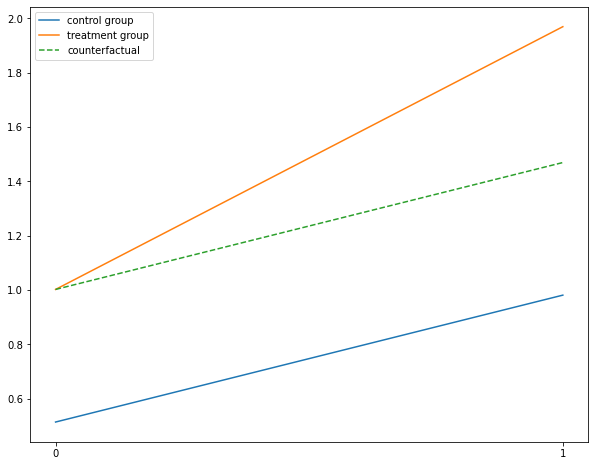

In [25]:
# read out the simulated data
Y00 = data[0]
Y01 = data[1]
Y10 = data[2]
Y11 = data[3]

# plot the control and treatment group
c = np.vstack((Y00, Y01))
t = np.vstack((Y10, Y11))

fig, ax = plt.subplots()
ax.plot(np.mean(c, axis=1), label='control group')
ax.plot(np.mean(t, axis=1), label='treatment group')
ax.plot(np.mean(c +(np.mean(Y10) - np.mean(Y00)), axis=1),'--', label='counterfactual')
plt.xticks(np.arange(0, 1.1, 1))
plt.legend()
plt.show()

Think about why this makes sense. If we simply computed the difference between the control and the treatment group, we would falsely attribute the difference between the treatment and the control group that existed prior to treatment to the treatment effect. If we simply computed the difference between the treatment group before and after treatment, however, we would falsely attribute the growth that seems to happen regardless of the treatment (the positive slope) to the treatment effect. Thus we need to control for the differences across time and across groups.  

The treatment effect is hence given as the difference between the counterfactual and the treatment group. The treatment effect can hence also be computed using:

| Y          |    D = 1                         |     D = 0                       | Difference  |
| :---       |    :----:                        |     :----:                      |     :----:  |
| T = 1      |$\bar {Y_{11}}$                   |$\bar {Y_{10}}$                  |$\bar {Y_{10}}$ - $\bar {Y_{11}}$|
| T = 0      |$\bar {Y_{01}}$                   |$\bar {Y_{00}}$                  |$\bar {Y_{00}}$ - $\bar {Y_{01}}$|
| Change     |$\bar {Y_{01}}$ - $\bar {Y_{11}}$ |$\bar {Y_{00}}$ - $\bar {Y_{10}}$|($\bar {Y_{00}}$ - $\bar {Y_{01}}$)-($\bar {Y_{10}}$ - $\bar {Y_{11}}$)| 

The bottom right cell thus gives us the treatment effect. We can hence also calculate it using the respective formula. 

In [26]:
TE = (np.mean(Y00)-np.mean(Y01))-(np.mean(Y10)-np.mean(Y11))
TE

0.500271401413526

It turns out, however, that we can also calculate the treatment effect using the following regression:

$$
Y = \alpha + \beta_1\cdot T + \beta_2\cdot  D + \beta_3\cdot (T\cdot D) + u
$$

In this case the treatment effect will be given as the coefficient on the interaction term, $\beta_3$. To see this, let us recycle our table from above and fill the cells with the regression coefficients that result conditional on $T$ and $D$.

| Y          |    D = 1     |   D = 0      | Difference  |
| :---       |    :----:    |   :----:     |     :----:  |
| T = 1      | 𝛼+𝛽1+𝛽2+𝛽3   |   𝛼+𝛽1       |  𝛽2+𝛽3      |
| T = 0      | 𝛼+𝛽2         |   𝛼          |  𝛽2         |
| Change     | 𝛽1+𝛽3        |   𝛽1         |  𝛽3         |

Before we proceed with estimation, we need to set up the treatment dummy ($D$) - indicating the before/after treatment period - and the dummy identifying the control and the treatment group ($T$). 

In [27]:
# concatenate the control and treatment groups with the T and D dummies
C = np.hstack((np.hstack((Y00, Y01))[:,None], np.vstack((np.zeros([N,1]), np.ones([N,1]))), np.zeros([2*N,1])))
T = np.hstack((np.hstack((Y10, Y11))[:,None], np.vstack((np.zeros([N,1]), np.ones([N,1]))), np.ones([2*N,1])))

# stack all observations
data = np.vstack((C, T))

# let's randmoize the row order and look at our data in a dataframe
data = pd.DataFrame(data, columns=['Y', 'T', 'D'])
data = data.sample(frac=1)
data['TD'] = data['T'] * data['D']
data.head()

,Y,T,D,TD
4253,1.726686,0.0,1.0,0.0
7522,1.127512,1.0,1.0,1.0
1084,-0.437296,0.0,0.0,0.0
5110,2.331875,0.0,1.0,0.0
893,2.082195,0.0,0.0,0.0


With the data in place, we can now run the regression above. 

In [28]:
# generate input arguments for regression
Y = np.asarray(data.Y)[:,None]
X = np.hstack((np.ones([Y.shape[0],1]), np.asarray(data['T'])[:,None], np.asarray(data.D)[:,None], np.asarray(data['TD'])[:,None]))

# run the regression
model = sm.OLS(Y, X)
results = model.fit()

# display output table
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     759.5
Date:                Fri, 23 Apr 2021   Prob (F-statistic):               0.00
Time:                        19:26:58   Log-Likelihood:                -11291.
No. Observations:                8000   AIC:                         2.259e+04
Df Residuals:                    7996   BIC:                         2.262e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5139      0.022     23.152      0.000       0.470       0.557
x1             0.4673      0.031     14.887      0.000       0.406       0.529
x2             0.4883      0.031     15.557      0.000       0.427       0.550
x3             0.5003      0.044     11.269      0.000       0.413       0.587
==============================================================================
Omnibus:                        2.558   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.278   Jarque-Bera (JB):                2.581
Skew:                          -0.043   Prob(JB):                        0.275
Kurtosis:                       2.980   Cond. No.                         6.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As you can see, $\beta_3$ in indeed the same as the treatment effect that we estimated above. 